<a href="https://colab.research.google.com/github/sid17905/sid17905-HEMO-EDGE/blob/main/HEMO_EDGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# --- 1. SET CREDENTIALS MANUALLY ---
# Replace the text inside the quotes with your actual details from the kaggle.json file
os.environ['KAGGLE_USERNAME'] = "1"  # Found in your screenshot
os.environ['KAGGLE_KEY'] = "KGAT_f30958f7579c6a76e3c7f0a46d156013" # You MUST get this from the downloaded file

# --- 2. DOWNLOAD DATASET ---
print("⬇️  Downloading C-NMC Dataset via API...")
import kaggle

# This downloads and unzips it to the current folder
!kaggle datasets download -d andrewmvd/leukemia-classification --unzip

print("✅ Download Complete! You can now run the 'Organize Data' script.")

⬇️  Downloading C-NMC Dataset via API...
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/leukemia-classification
License(s): other
 92% 798M/867M [00:06<00:01, 44.7MB/s]
100% 867M/867M [00:06<00:00, 130MB/s] 
✅ Download Complete! You can now run the 'Organize Data' script.


In [ ]:
import tensorflow as tf
import os
import shutil
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

print("--- 🚀 HEMO-EDGE: COLAB TPU TRAINING ---")

# --- 0. CLEANUP (Optional) ---
tf.keras.backend.clear_session()

# --- 1. TPU SETUP ---
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('✅ Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('✅ Running on TPU with', strategy.num_replicas_in_sync, 'cores')
except ValueError:
    print('❌ TPU not found. Using CPU/GPU.')
    strategy = tf.distribute.get_strategy()

# --- 2. PREPARE DATA (Auto-Unzip & Organize) ---
ZIP_FILE = "leukemia-classification.zip"
SOURCE_ROOT = "C-NMC_Leukemia/training_data"
DEST_ROOT = "dataset_final"

# A. Unzip if needed
if not os.path.exists(SOURCE_ROOT):
    if os.path.exists(ZIP_FILE):
        print(f"📦 Unzipping {ZIP_FILE}...")
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            zip_ref.extractall(".")
        print("✅ Unzip Complete.")
    else:
        print(f"⚠️ Warning: Could not find {ZIP_FILE} or {SOURCE_ROOT}. Make sure file is uploaded!")

# B. Organize into Normal/Blast folders
if not os.path.exists(DEST_ROOT):
    print("📂 Organizing dataset structure...")
    os.makedirs(f"{DEST_ROOT}/Normal", exist_ok=True)
    os.makedirs(f"{DEST_ROOT}/Blast", exist_ok=True)

    folds = ["fold_0", "fold_1", "fold_2"]
    count = 0

    for fold in folds:
        fold_path = os.path.join(SOURCE_ROOT, fold)
        if os.path.exists(fold_path):
            # Move Cancer (all) -> Blast
            all_path = os.path.join(fold_path, "all")
            if os.path.exists(all_path):
                for f in os.listdir(all_path):
                    if f.endswith(".bmp"):
                        shutil.copy(os.path.join(all_path, f), f"{DEST_ROOT}/Blast")
                        count += 1

            # Move Normal (hem) -> Normal
            hem_path = os.path.join(fold_path, "hem")
            if os.path.exists(hem_path):
                for f in os.listdir(hem_path):
                    if f.endswith(".bmp"):
                        shutil.copy(os.path.join(hem_path, f), f"{DEST_ROOT}/Normal")
                        count += 1
    print(f"✅ Data Organized! Moved {count} images.")
else:
    print("ℹ️  'dataset_final' already exists. Skipping organization.")

# --- 3. TRAIN MODEL ---
IMG_SIZE = 224
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # Speed boost (16 * 8 = 128)
EPOCHS = 15

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.2
)

print("\n📊 Loading Generators...")
train_gen = datagen.flow_from_directory(
    DEST_ROOT, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary', subset='training'
)

val_gen = datagen.flow_from_directory(
    DEST_ROOT, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary', subset='validation'
)

# CRITICAL: Print this so we know the labels!
print(f"🔍 Class Mapping: {train_gen.class_indices}")
# Likely outputs: {'Blast': 0, 'Normal': 1}

with strategy.scope():
    print("🏗️ Building MobileNetV2...")
    base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("🚀 Starting Training...")
model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

# --- 4. SAVE & QUANTIZE (The Final Step) ---
model.save('hemo_edge_tpu_model.h5')
print("✅ Full Model Saved.")

print("📉 Quantizing to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('hemo_edge_quantized.tflite', 'wb') as f:
    f.write(tflite_model)

print("🎉 DONE! Download 'hemo_edge_quantized.tflite' from the files sidebar.")

--- 🚀 HEMO-EDGE: COLAB TPU TRAINING ---
❌ TPU not found. Using CPU/GPU.
ℹ️  'dataset_final' already exists. Skipping organization.

📊 Loading Generators...
Found 8530 images belonging to 2 classes.
Found 2131 images belonging to 2 classes.
🔍 Class Mapping: {'Blast': 0, 'Normal': 1}
🏗️ Building MobileNetV2...
🚀 Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 194s 330ms/step - accuracy: 0.7620 - loss: 0.5077 - val_accuracy: 0.7180 - val_loss: 0.6283
Epoch 2/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 129s 242ms/step - accuracy: 0.8286 - loss: 0.4108 - val_accuracy: 0.7086 - val_loss: 0.6241
Epoch 3/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 129s 241ms/step - accuracy: 0.8430 - loss: 0.3903 - val_accuracy: 0.6781 - val_loss: 0.6551
Epoch 4/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 127s 238ms/step - accuracy: 0.8409 - loss: 0.3877 - val_accuracy: 0.7203 - val_loss: 0.6018
Epoch 5/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 146s 274ms/step - accuracy: 0.8454 - loss: 0.3774 - val_accuracy: 0.7302 - val_loss: 0.6148
Epoch 6/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 126s 236ms/step - accuracy: 0.8374 - loss: 0.3870 - val_accuracy: 0.7039 - val_loss: 0.6059
Epoch 7/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 126s 236ms/step - accuracy: 0.8345 - loss: 0.3849 - val_accuracy: 0.6818 - val_loss: 0.6242
Epoch 8/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 128s 239ms/step - accuracy: 0.8450 -

✅ Full Model Saved.
📉 Quantizing to TFLite...
Saved artifact at '/tmp/tmpsf5t8may'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139228554937168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228554941200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228554941584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228554940816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228554940048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228554941392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228554941776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228554942544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228554942160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139228554938896: TensorSpec(shape=(), 

--- 🩺 HEMO-EDGE: MODEL INTERPRETATION & TESTING ---
✅ Model Loaded Successfully!
📊 Testing on 100 images (Blast=0, Normal=1)...


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


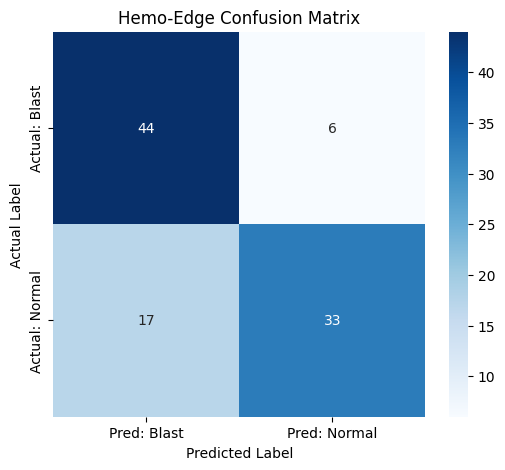


📝 DETAILED METRICS:
              precision    recall  f1-score   support

       Blast       0.72      0.88      0.79        50
      Normal       0.85      0.66      0.74        50

    accuracy                           0.77       100
   macro avg       0.78      0.77      0.77       100
weighted avg       0.78      0.77      0.77       100


👀 VISUALIZING RANDOM RESULTS:


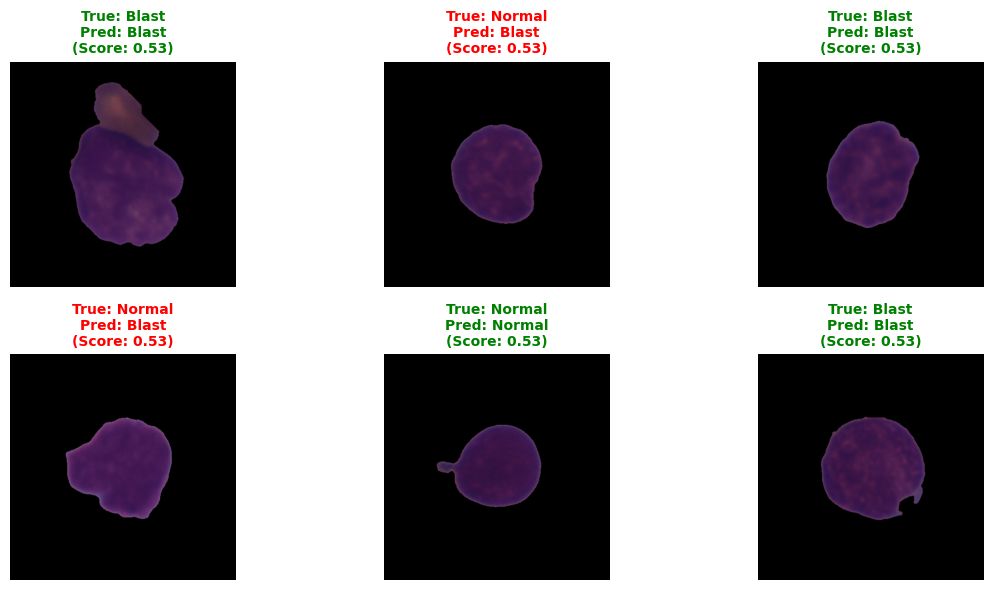

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2
import random

# --- CONFIGURATION ---
MODEL_PATH = "hemo_edge_quantized.tflite"
DATASET_PATH = "dataset_final"
IMG_SIZE = 224

print("--- 🩺 HEMO-EDGE: MODEL INTERPRETATION & TESTING ---")

# --- 1. LOAD TFLITE MODEL ---
if not os.path.exists(MODEL_PATH):
    print(f"❌ Error: {MODEL_PATH} not found! Run the Training step first.")
else:
    interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print("✅ Model Loaded Successfully!")

# --- 2. GATHER TEST DATA (FIXED LABELS) ---
# TensorFlow Alphabetical Order: 0 = Blast, 1 = Normal
test_images = []
test_labels = []

# Load Blast (Class 0)
blast_path = os.path.join(DATASET_PATH, "Blast")
if os.path.exists(blast_path):
    # Take 50 images
    for f in os.listdir(blast_path)[:50]:
        test_images.append(os.path.join(blast_path, f))
        test_labels.append(0) # <--- FIXED: Blast is 0

# Load Normal (Class 1)
normal_path = os.path.join(DATASET_PATH, "Normal")
if os.path.exists(normal_path):
    # Take 50 images
    for f in os.listdir(normal_path)[:50]:
        test_images.append(os.path.join(normal_path, f))
        test_labels.append(1) # <--- FIXED: Normal is 1

print(f"📊 Testing on {len(test_images)} images (Blast=0, Normal=1)...")

# --- 3. RUN INFERENCE ---
predictions = []

for img_path in test_images:
    # Preprocess
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    input_data = np.expand_dims(img, axis=0)

    # Quantization Check
    if input_details[0]['dtype'] == np.float32:
        input_data = (input_data / 255.0).astype(np.float32)
    else:
        input_data = input_data.astype(np.uint8)

    # Run Model
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get Score
    score = output_data[0][0]

    if output_details[0]['dtype'] == np.uint8:
        score = score / 255.0

    # Threshold: score > 0.5 means Class 1 (Normal), else Class 0 (Blast)
    predictions.append(1 if score > 0.5 else 0)

# --- 4. GENERATE CONFUSION MATRIX ---
# Note: Labels are now 0=Blast, 1=Normal
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Blast', 'Pred: Normal'],
            yticklabels=['Actual: Blast', 'Actual: Normal'])
plt.title('Hemo-Edge Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 5. PRINT CLASSIFICATION REPORT ---
# Target names must match the order [0, 1] -> [Blast, Normal]
print("\n📝 DETAILED METRICS:")
print(classification_report(test_labels, predictions, target_names=['Blast', 'Normal']))

# --- 6. VISUALIZE SOME PREDICTIONS ---
print("\n👀 VISUALIZING RANDOM RESULTS:")
plt.figure(figsize=(12, 6))
if len(test_images) > 0:
    indices = random.sample(range(len(test_images)), min(6, len(test_images)))

    for i, idx in enumerate(indices):
        img = cv2.imread(test_images[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # FIX LABELS FOR DISPLAY
        true_lbl = "Normal" if test_labels[idx] == 1 else "Blast"
        pred_lbl = "Normal" if predictions[idx] == 1 else "Blast"

        color = "green" if true_lbl == pred_lbl else "red"

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_lbl}\nPred: {pred_lbl}\n(Score: {score:.2f})", color=color, fontweight='bold', fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("❌ No test images found!")